# Daily run script to generate playlists followers reports

### 0. Import libraries

In [45]:
import sys
sys.path.append("../../")

from src.common.spotify_auth import sp
from src.common.config import setup_logger

from spotipy import Spotify
import pandas as pd
import requests
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

from io import BytesIO
from PIL import Image
import os
import logging

### 1. Custom functions

In [46]:
def get_playlists_data(sp: Spotify, cover_images_folder: str) -> pd.DataFrame:
    playlists = sp.current_user_playlists()
    data = {}
    
    for playlist in playlists['items']:
        name = playlist['name']
        name = "_".join(name.split())
        playlist_id = playlist['id']
        
        # looking for the playlist based on id to get details
        playlist_details = sp.playlist(playlist_id)
        followers = playlist_details['followers']['total']
        data.update({name : int(followers)})        
        
        # getting and saving playlist cover to a file
        cover_url = playlist_details['images'][0]['url']
        response = requests.get(cover_url)
        response.raise_for_status()
        cover_image = Image.open(BytesIO(response.content))
        cover_image.save(f"{cover_images_folder}/{name}.png")
      
    data_df = pd.DataFrame(data = [data])
    data_df.index = [pd.to_datetime(date.today())]

    return data_df

In [47]:
def update_the_historical_data(data_df: pd.DataFrame, csv_url: str = "../data/follower_count.csv") -> pd.DataFrame:
    
    hist_df = pd.read_csv(csv_url, index_col = 0)
    
    hist_df.index = pd.to_datetime(hist_df.index)
    hist_df = hist_df.astype(int)
    
    try:
        updated_df = pd.concat([hist_df, data_df], verify_integrity=True)
        
        updated_df.to_csv(csv_url)
    
    except ValueError:
        common_indexes = hist_df.index.intersection(data_df.index)
        hist_df = hist_df.drop(index=common_indexes)
        updated_df = pd.concat([hist_df, data_df], verify_integrity=True)
        updated_df.to_csv(csv_url)

    
    return updated_df

In [48]:
def create_followers_chart(followers_df: pd.DataFrame, days_traceback: int = 365):
    
    sns.set_style("white", {"grid.color": "#2A2A2A"})

    fig, ax = plt.subplots(figsize=(7, 2))

    last_30_days_df = followers_df[followers_df.index > pd.Timestamp(date.today()) - timedelta(days=days_traceback)]
    sns.lineplot(data=last_30_days_df, ax=ax, color='#45ad61', linewidth=4)

    ax.set_ylabel("", fontsize=5, color='white')
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='y', labelleft=False)
    ax.legend().remove()

    ax.grid(color='#808080', axis='y', linestyle='-', linewidth=0.5)

    sns.despine()

    plt.tight_layout()
    name = "_".join(last_30_days_df.name.split())
    plt.savefig(f"../data/assets/charts/{name}_last_month_chart.png")

In [49]:
def generate_follower_report(name : str,
                             charts_url: str,
                             covers_url: str,
                             followers_df: pd.DataFrame,
                             logger: logging.Logger,
                             chart_width: int = 140, 
                             chart_height: int = 40,
                             cover_size: int = 30,
                             margin: int = 20,
                             horizontal_margin: int = 60,
                             title_margin: int = 5,
                             outline_margin: int = 3,
                             main_font_size: int = 10,
                             secondary_font_size = 9,
                             columns: int = 3, 
                             page_height: float = A4[1]):
    
    x, y = margin, page_height - chart_height
    c = canvas.Canvas(name, pagesize=A4)
    
    # Report title
    title = date.today().strftime("%d.%m.%Y") + " PulseBeats playlists followers report"
    c.setFont("Helvetica-Bold", main_font_size * 2)
    c.drawString(x, 
                 y, 
                 title)
    
    y -= chart_height

    for i, playlist_name in enumerate(followers_df.columns):
        chart_path = f'{charts_url}/{playlist_name}_last_month_chart.png'
        cover_path = f'{covers_url}/{playlist_name}.png'
        current_followers = followers_df[playlist_name].iloc[-1]
        a_week_ago_delta = current_followers - followers_df[playlist_name].iloc[-8]
        a_month_ago_delta = current_followers - followers_df[playlist_name].iloc[-31]

        try:
            # playlist cover
            c.drawImage(cover_path, 
                        x, 
                        y - cover_size, 
                        width=cover_size, 
                        height=cover_size)

            # playlist title
            display_name = " ".join((playlist_name.split('.')[0]).split("_"))
            if len(display_name) > 20:
                display_name = display_name[:20] + "..."
                
            c.setFont("Helvetica-Bold", main_font_size)
            c.drawString(x + cover_size + title_margin, 
                         y - main_font_size + 2, 
                         display_name)
            
            # current followers count
            c.setFont("Helvetica-Bold", main_font_size)
            c.drawString(x + cover_size + title_margin, 
                         y - main_font_size * 2 - outline_margin, 
                         str(current_followers))
            
            # week's growth
            c.setFont("Helvetica-Bold", secondary_font_size)
            c.drawString(x, 
                         y - cover_size - chart_height - secondary_font_size, 
                         "In the last week: ")
            if a_week_ago_delta > 0:
                c.setFillColorRGB(0.27, 0.68, 0.38)
            else:
                c.setFillColorRGB(0.68, 0.27, 0.27)
            display_week_value = f'+{a_week_ago_delta}' if a_week_ago_delta > 0 else f'{a_week_ago_delta}'
            c.drawString(x + 80, 
                        y - cover_size - chart_height - secondary_font_size, 
                        display_week_value)
            c.setFillColorRGB(0, 0, 0)
            
            # month's growth
            c.setFont("Helvetica-Bold", secondary_font_size)
            c.drawString(x, 
                         y - cover_size - chart_height - secondary_font_size * 2 - outline_margin, 
                         "In the last month: ")
            if a_month_ago_delta > 0:
                c.setFillColorRGB(0.27, 0.68, 0.38)
            else:
                c.setFillColorRGB(0.68, 0.27, 0.27)
            display_month_value = f'+{a_month_ago_delta}' if a_month_ago_delta > 0 else f'{a_month_ago_delta}'
            c.drawString(x + 80, 
                        y - cover_size - chart_height - secondary_font_size * 2 - outline_margin, 
                        display_month_value)
            c.setFillColorRGB(0, 0, 0)

            # line plot image
            c.drawImage(chart_path, 
                        x - outline_margin, 
                        y - cover_size - chart_height, 
                        width=chart_width, 
                        height=chart_height)

            # x pos update
            x += chart_width + horizontal_margin
            if (i + 1) % columns == 0:
                x = margin  # reset x
                y -= 130  # new line

                # new page if theres no space
                if y < margin + cover_size:
                    c.showPage()
                    y = page_height - cover_size - chart_height - 2 * margin
                    
        except Exception as e:
            logger.error(f"Error while generating the followers report: {e}")

    c.save()

### 2. Envinroment variables

In [50]:
report_name = "../data/follower_report.pdf"
charts_url = "../data/assets/charts"
covers_url = "../data/assets/covers"

### 3. Run the code

In [51]:
logger = setup_logger("followers_reporting.py")
logger.info('Starting job initialization.')

2025-05-17 13:21:22 | INFO | followers_reporting.py | Starting job initialization.



In [52]:
df = get_playlists_data(sp, covers_url)

In [53]:
updated_df = update_the_historical_data(df)

C:\Users\damia\AppData\Local\Temp\ipykernel_3228\209655987.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\damia\AppData\Local\Temp\ipykernel_3228\209655987.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\damia\AppData\Local\Temp\ipykernel_3228\209655987.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\damia\AppData\Local\Temp\ipykernel_3228\209655987.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with 

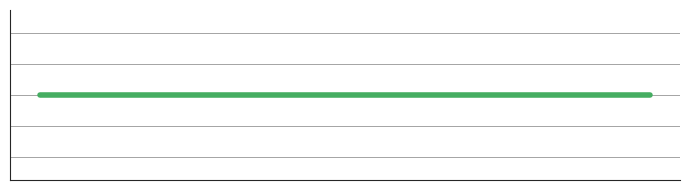

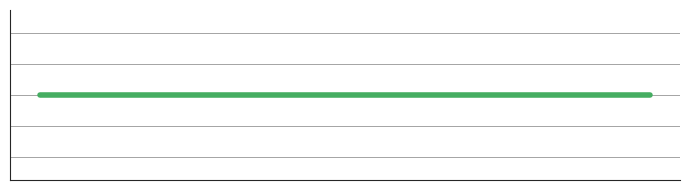

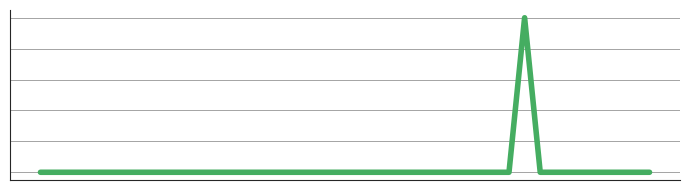

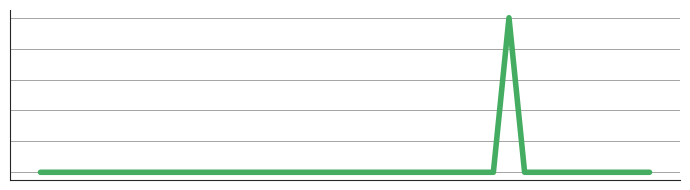

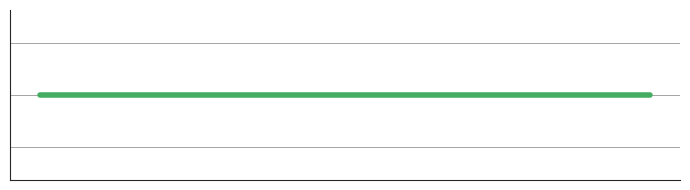

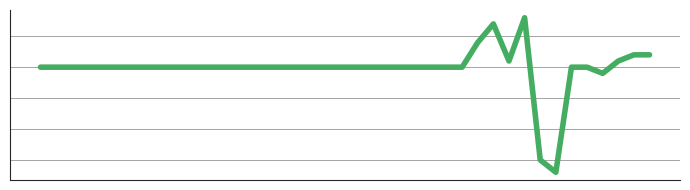

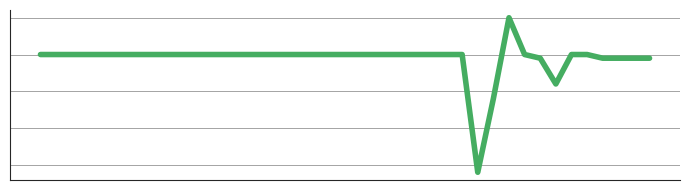

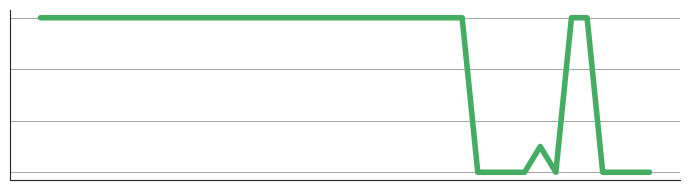

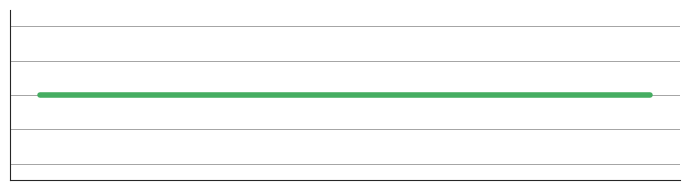

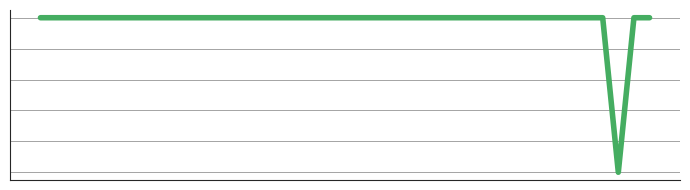

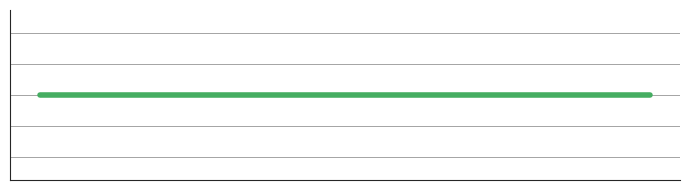

In [54]:
for col in updated_df.columns:
    create_followers_chart(updated_df[col])


In [55]:
generate_follower_report(report_name, 
                         charts_url, 
                         covers_url,
                         updated_df,
                         logger)